In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('./1-4/')
from lr_utils import load_dataset

In [2]:
# import dataset
X_train, Y_train, X_test, Y_test, classes = load_dataset()
X_train = X_train.reshape((X_train.shape[0], -1)).T / 255
X_test = X_test.reshape((X_test.shape[0], -1)).T / 255
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'Y_train.shape = {Y_train.shape}')
print(f'Y_test.shape = {Y_test.shape}')

X_train.shape = (12288, 209)
X_test.shape = (12288, 50)
Y_train.shape = (1, 209)
Y_test.shape = (1, 50)


In [60]:
#  I have already implement model 'Layer' and 'Model' in practice 1-3

def tanh(x):
    s = np.tanh(x)
    return s

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

def ReLU(x):
    s = np.maximum(x, 0)
    return s


class Layer(object):
    '''
    implement general Layer which can fowardpropagate and 
    backpropagate with parameters like W,b and so on as it's
    attributes.

    initial parameters of a Layer instance：

    n_input: int, number of input features
    n_layer: int, number of layer units
    activate: function, chose from [tanh, sigmoid, ReLU]
    name: str, default None, optional
    '''
    def __init__(self, n_input, n_layer, activate, name=None):
        self.n = n_layer
        self.name = name
        self.activate = activate
        self.X = None
        # self.W = np.random.randn(n_layer, n_input) * 1e-4
        self.W = np.random.randn(n_layer, n_input) * np.sqrt(2/n_input)
        self.b = np.zeros((n_layer, 1))
        self.Z = None
        self.A = None
        self.dA = None
        self.dZ = None
        self.dW = None
        self.db = None
        self.dX = None

    def get_W(self):
        return self.W

    def get_b(self):
        return self.b

    def get_A(self):
        return self.A

    def get_dX(self):
        return self.dX    

    def fwprop(self, X):
        self.X = X
        self.Z = np.dot(self.W, self.X) + self.b
        self.A = self.activate(self.Z)

    def bkprop(self, dA, alpha):
        self.dA = dA
        if self.activate == tanh:
            self.dZ = self.dA * (1 - self.A**2)
        elif self.activate == sigmoid:
            self.dZ = self.dA * self.A * (1 - self.A)
        elif self.activate == ReLU:
            self.dZ = self.dA * (self.A > 0)
        else:
            print('Wrong activate function!')
        self.dX = np.dot(self.W.T, self.dZ)
        self.dW = np.dot(self.dZ, self.X.T)
        self.db = np.mean(self.dZ, axis=1).reshape((self.n, 1))
        self.W -= alpha * self.dW
        self.b -= alpha * self.db



class Model(object):
    '''
    implement general Model which can add layer, fowardpropagate, compute 
    cost, backpropagate, train, predict and score.

    layer list can be found in the attribute Model.layers.
    
    parameters like W,b can be found in attributes of layers in the
    layer list.

    initial parameters of a Model instance：

    X_train: np.ndarray, input of training data
    Y_train: np.ndarray, output of training data
    alpha: float, learning rate, default to be 0.005
    loops: int, number of iteration you want to train, default 2000
    '''
    def __init__(self, X_train, Y_train, alpha=0.005, loops=2000):
        self.X = X_train
        self.Y = Y_train
        self.alpha = alpha
        self.loops = loops
        self.L = 0
        self.layers = []
        self.layers_reverse = []
        self.A = None
        self.J = None
        self.J_list = []

    def add_layer(self, n_input, n_layer, activate, name=None):
        self.L += 1
        new_layer = Layer(n_input, n_layer, activate, name=name)
        self.layers.append(new_layer)
        self.layers_reverse = self.layers.copy()
        self.layers_reverse.reverse()
        return new_layer

    def fwprop(self):
        input_ = self.X
        for layer in self.layers:
            layer.fwprop(input_)
            input_ = layer.get_A()

    def compute_J(self):
        self.A = self.layers[-1].get_A()
        # 防止出现log(0)等于nan的情况, 每次log()内加上极小正数
        self.J = (-self.Y * np.log(self.A + 1e-10) - (1 - self.Y) * np.log(1 - self.A + 1e-10)).mean()

    def bkprop(self):
        # 防止出现x / 0等于nan的情况, 每次 / 分母加上极小正数
        dA = -self.Y / (self.A +10e-10) + (1 - self.Y) / (1 - self.A +10e-10)
        for layer in self.layers_reverse:
            layer.bkprop(dA, alpha=self.alpha)
            dA = layer.get_dX()

    def train(self):
        for i in range(self.loops):
            self.fwprop()
            self.compute_J()
            self.bkprop()
            self.J_list.append(self.J)
            j = i + 1
            if j%50 == 0:
                print(f'loss of iteration No.{j}: {self.J}')

    def predict(self, X_test):
        for layer in self.layers:
            layer.fwprop(X_test)
            X_test = layer.get_A()
        return X_test

    def score(self, X_test, Y_test):
        Y_predict = self.predict(X_test)
        result = (Y_predict > 0.5) == Y_test
        acc = result.mean()
        return acc

    def plot_loss(self):
        plt.plot(self.J_list)
        plt.xlabel('step')
        plt.ylabel('loss')
        plt.title('loss circle')
        plt.show()


In [61]:
model_2l = Model(X_train, Y_train, alpha=0.00001, loops=4000)
model_2l.add_layer(12288, 7, ReLU, name='hiden layer with 7 units')
model_2l.add_layer(7, 1, sigmoid, name='output layer')
model_2l.train()

loss of iteration No.50: 0.6314187210353828
loss of iteration No.100: 0.6071195895314415
loss of iteration No.150: 0.5872700836317767
loss of iteration No.200: 0.5691658184240235
loss of iteration No.250: 0.5521352135673449
loss of iteration No.300: 0.5350606134444318
loss of iteration No.350: 0.5196926831185271
loss of iteration No.400: 0.5049700177607459
loss of iteration No.450: 0.4898894206874169
loss of iteration No.500: 0.47500815220252596
loss of iteration No.550: 0.4604318425874768
loss of iteration No.600: 0.4463371771181034
loss of iteration No.650: 0.43302403900428404
loss of iteration No.700: 0.42027057982935234
loss of iteration No.750: 0.4075907466117048
loss of iteration No.800: 0.3955770392306733
loss of iteration No.850: 0.38381494998912835
loss of iteration No.900: 0.372355170745898
loss of iteration No.950: 0.3613149377408312
loss of iteration No.1000: 0.35072669590073813
loss of iteration No.1050: 0.3406276705853834
loss of iteration No.1100: 0.33039275764122406
los

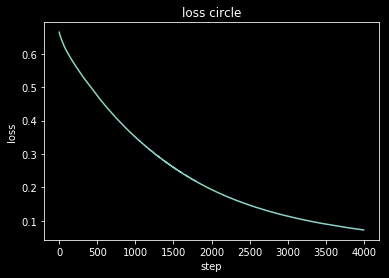

In [62]:
model_2l.plot_loss()

In [63]:
print('final loss:', model_2l.J)
print('the 2 Lyaers model\'s accuracy:', model_2l.score(X_test, Y_test))
# 试了不同的学习率和参数初始化, 有时候同样的参数得到的结果却很差, 有点靠运气的意思, 以后用后面课程的知识再试
# 这次的曲线是最好的, 损失值能降下来, 并且学习率也合适曲线没有波动, 但不是loss和accuracy最好的一次
# 在此基础上继续训练应该能得到更好的损失值

final loss: 0.07268165369975439
the 2 Lyaers model's accuracy: 0.7


In [77]:
np.random.seed(10)
model_4l = Model(X_train, Y_train, alpha=0.00001, loops=4000)
model_4l.add_layer(12288, 20, ReLU, name='hiden layer 1 with 20 units active by ReLU')
model_4l.add_layer(20, 7, ReLU, name='hiden layer 2 with 7 units active by ReLU')
model_4l.add_layer(7, 5, ReLU, name='hiden layer 3 with 5 units active by ReLU')
model_4l.add_layer(5, 1, sigmoid, name='output layer active by sigmoid')
model_4l.train()

loss of iteration No.50: 0.6004047868703344
loss of iteration No.100: 0.5580382122750355
loss of iteration No.150: 0.5229659497069502
loss of iteration No.200: 0.4901974088534307
loss of iteration No.250: 0.46636223836705737
loss of iteration No.300: 0.4421587072713555
loss of iteration No.350: 0.41396583992550073
loss of iteration No.400: 0.3957210570971305
loss of iteration No.450: 0.37975835957305487
loss of iteration No.500: 0.36049288777398536
loss of iteration No.550: 0.3422250989543366
loss of iteration No.600: 0.32149224952878463
loss of iteration No.650: 0.2993032665858138
loss of iteration No.700: 0.28007572668771735
loss of iteration No.750: 0.25931079869447254
loss of iteration No.800: 0.23586039434339146
loss of iteration No.850: 0.22168018411016796
loss of iteration No.900: 0.19765929157858989
loss of iteration No.950: 0.18215778473748148
loss of iteration No.1000: 0.166316523607987
loss of iteration No.1050: 0.14974080832597086
loss of iteration No.1100: 0.13672371058956

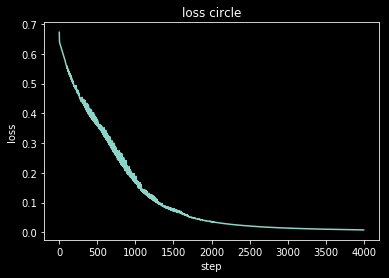

hiden layer 1 with 20 units active by ReLU
hiden layer 2 with 7 units active by ReLU
hiden layer 3 with 5 units active by ReLU
output layer active by sigmoid


In [80]:
model_4l.plot_loss()
for layer in model_4l.layers:
    print(layer.name)

In [81]:
print('final loss:', model_4l.J)
print('the 4 Lyaers model\'s accuracy:', model_4l.score(X_test, Y_test))
# 我试验了多种初始化参数的方法, 试验了不同的随机种子, 不同的学习率, 大部分失败, 损失值降不下来
# 多层网络中这一次的结果最好, 损失值足够小, 但测试集上的准确率依然和1-2层网络相近
# 如果只用目前的课程知识, 随机初始化参数几乎纯靠运气, 学习率可以根据损失曲线来调, 最好不要间隔取点
# 调参方法: 建议确定好随机初始化函数后, 现调整random seed找到能使loss可以下降的随机数组, 在根据loss circle调整学习率
# 本例中曲线还有震荡, 可以尝试更小的学习率, 不过最终下降的还算令人满意
# 可能是过拟合的原因, 如果在2000次迭代处停下来可能可以得到更好的准确率

final loss: 0.00793330214057926
the 4 Lyaers model's accuracy: 0.7
